In [10]:
using Pkg

Pkg.DEFAULT_IO[] = stdout
Pkg.activate("../.")

Pkg.add(url="https://github.com/ClimateFluidPhysics-ANU/MixedLayerThermoclineDynamics.jl", rev="master")

  Activating environment at `~/Desktop/PhD/Codes/julia_package/ToyModel.jl/Project.toml`


    Updating git-repo `https://github.com/ClimateFluidPhysics-ANU/MixedLayerThermoclineDynamics.jl`
    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/Desktop/PhD/Codes/julia_package/ToyModel.jl/Project.toml`
  No Changes to `~/Desktop/PhD/Codes/julia_package/ToyModel.jl/Manifest.toml`


In [11]:
using Plots
using BenchmarkTools
using CircularArrays
using MixedLayerThermoclineDynamics

include("../Staggered/Grid/Periodic_avg.jl")
include("../Staggered/Advection/Periodic_1D.jl")

adv_x_Euler! (generic function with 1 method)

In [5]:
g = 9.81

Lx = 6
nx = 100
grid = Grid1D(nx, -Lx/2, Lx/2);

In [8]:
#Initialising variables
xt = grid.xC
xu = grid.xF
dx = grid.dx

#Tracer and momentum variables
h_old = zeros(nx)
@. h_old = 1 + 0.01*exp(-5*xt^2)
h_new = zeros(nx)
u_old = zeros(nx)
u_new = zeros(nx)

#Equation variables, modified several times at every time step
adv = zeros(nx)
dudx = zeros(nx)
dhdx = zeros(nx)
dhdx_no = zeros(nx)
u_avg = zeros(nx)
h_avg = zeros(nx)

#Time variables
t_start = 0
t_end = 1.5
dt = 0.001

#Needed for making animations
n_steps = Int(t_end/dt)
h_data = zeros(nx, n_steps+1)
count = 1

for t in t_start:dt:t_end
    adv_x_Euler!(adv, dudx, u_old, u_old, grid)
    ∂xt_cd!(dhdx, h_old, grid, true)
    ∂xu_cd!(dudx, u_old, grid, true)
    ∂xt_cd!(dhdx_no, h_old, grid, false)
    avg_val(u_old, h_old, u_avg, h_avg)
    
    @. u_new = u_old - dt*adv - dt*g*dhdx
    @. h_new = h_old - dt*u_avg*dhdx_no - dt*h_old*dudx
    
    u_old = u_new
    h_old = h_new
    
    h_data[:, count] = h_old
    count = count+1
end

┌ Info: Saved animation to 
│   fn = /Users/dhruvbhagtani/Desktop/PhD/Codes/julia_package/ToyModel.jl/1D_SWE/ShallowWater_Staggered.gif
└ @ Plots /Users/dhruvbhagtani/.julia/packages/Plots/XCJgc/src/animation.jl:104


Plots.AnimatedGif("/Users/dhruvbhagtani/Desktop/PhD/Codes/julia_package/ToyModel.jl/1D_SWE/ShallowWater_Staggered.gif")
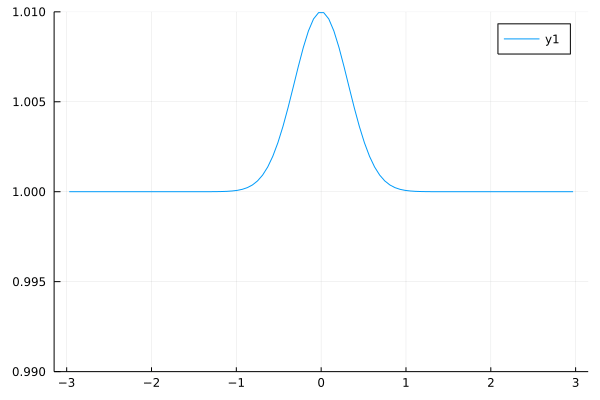

In [12]:
skip = Int(20)
anim = @animate for i in 1:skip:n_steps
    plot(xt, h_data[:, i])
    plot!(ylims = (1 - 0.01, 1 + 0.01))
end
 
gif(anim, "ShallowWater_Staggered.gif", fps = 8)